![HenryLogo](https://d31uz8lwfmyn8g.cloudfront.net/Assets/logo-henry-white-lg.png)

# **Proyecto integrador**

### 3. Modelamiento

Una vez preparados los datos, se procederá con el modelamiento. Recuerden que el objetivo es clasificar a un paciente como hospitalizado o no hospitalizado, teniendo en cuenta un data set que contiene información referente a antecedentes del paciente, morbilidad asociada al paciente y antecedentes relacionados con la toma de la biopsia y complicaciones infecciosas.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report


sns.set_style("darkgrid")
import warnings
warnings.simplefilter("ignore")
import plotly.express as px
pd.set_option('display.max_columns', None)

Carguen la base de datos preparada desde la fase 2.

In [2]:
df_main = pd.read_csv('datasets/BBDD_hospitalizacion_2encod.csv')
df_main

,edad,diabetes,psa,biop_prev,vol_prostatico,antib_en_profilaxis,n_muestras,e_cpo,biopsia,fiebre,itu,tipo_cultivo,hospitalizacion
0,53,0,4.0,0,1,1,12,0,7,1,0,2,1
1,56,0,7.7,0,1,1,12,0,7,1,0,2,1
2,57,0,29.0,1,1,1,24,0,7,1,0,0,1
3,56,0,7.0,0,1,1,12,0,7,1,0,2,1
4,55,0,29.0,1,1,1,24,0,7,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,55,0,5.0,0,0,1,12,0,2,0,0,2,0
429,70,1,18.0,0,1,1,12,0,7,0,0,2,0
430,75,0,75.0,0,1,1,12,0,3,0,0,2,0
431,67,0,6.0,0,1,1,12,0,1,0,0,2,0


In [3]:
# Crear un gráfico de barras con Plotly Express
fig = px.histogram(df_main, x='hospitalizacion', color='hospitalizacion')

# Configurar el título con solo *hospitalizacion* en negrita
fig.update_layout(
    title='Distribución de la Variable <b>hospitalizacion</b>',
    xaxis_title='Hospitalización',
    yaxis_title='Cantidad',
    font=dict(size=12),
    title_x=0.5
)

# Mostrar el gráfico
fig.show()


Se identifica un significativo desequilibrio de clases en la variable objetivo, donde la clase positiva para la hospitalización cuenta con tan solo 23 registros. En consecuencia, se ha tomado la decisión de llevar a cabo un sobremuestreo de dicha variable con el objetivo de abordar esta disparidad.

Separen el dataset en X, y (variable objetivo)

In [4]:
# Separar el dataset en X e y
X = df_main.drop('hospitalizacion', axis=1)
y = df_main['hospitalizacion']

Separen el dataset en X_train, X_test, y_train y y_test

In [5]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Información sobre las etiquetas en el conjunto de entrenamiento
print(f'Instancias clasificadas como NO en el conjunto de entrenamiento: {y_train.value_counts()[0]}')
print(f'Instancias clasificadas como SI en el conjunto de entrenamiento: {y_train.value_counts()[1]}')

# Detalles sobre las etiquetas en el conjunto de prueba
print(f'Instancias clasificadas como NO en el conjunto de prueba: {y_test.value_counts()[0]}')
print(f'Instancias clasificadas como SI en el conjunto de prueba: {y_test.value_counts()[1]}')

Instancias clasificadas como NO en el conjunto de entrenamiento: 287
Instancias clasificadas como SI en el conjunto de entrenamiento: 16
Instancias clasificadas como NO en el conjunto de prueba: 123
Instancias clasificadas como SI en el conjunto de prueba: 7


In [6]:
# Se crea una instancia de RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Se aplica el sobremuestreo a los datos de entrenamiento
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Información sobre las etiquetas después del sobremuestreo en el conjunto de entrenamiento
print(f'Instancias clasificadas como NO después de sobremuestreo: {y_train_ros.value_counts()[0]}')
print(f'Instancias clasificadas como SI después de sobremuestreo: {y_train_ros.value_counts()[1]}')

Instancias clasificadas como NO después de sobremuestreo: 287
Instancias clasificadas como SI después de sobremuestreo: 287


Instancien, entrenen y predigan sobre un árbol de decisión asignando una profundidad máxima arbitraria

In [7]:
# Define el rango de hiperparámetros para KNN el GridSearch
param_grid_knn = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'leaf_size':[1,3,5,7,10],
    'algorithm':['auto', 'kd_tree']
}

# Define el rango de hiperparámetros para tre el GridSearch
param_grid_tree = {
    "criterion": ['gini', 'entropy'],
    "max_depth": range(1, 20)
}

# Define el rango de hiperparámetros para SVC el GridSearch
param_grid_SVC = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

In [8]:
# Se crea una lista para almacenar los resultados de diferentes modelos
results = []

# Parámetros para Grid Search en KNN
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}

# Parámetros para Grid Search en Decision Tree
param_grid_tree = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}

# Parámetros para Grid Search en SVC
param_grid_SVC = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}

# Se instancia y evalua el modelo K-NN
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5)
grid_search_knn.fit(X_train_ros, y_train_ros)

best_knn_estimator = grid_search_knn.best_estimator_
best_knn_params = grid_search_knn.best_params_

y_pred_test_knn = best_knn_estimator.predict(X_test)
y_pred_train_knn = best_knn_estimator.predict(X_train_ros)

cm_train_knn = confusion_matrix(y_train_ros, y_pred_train_knn)
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn)

train_accuracy_knn = accuracy_score(y_train_ros, y_pred_train_knn)
train_precision_knn = precision_score(y_train_ros, y_pred_train_knn)
train_recall_knn = recall_score(y_train_ros, y_pred_train_knn)
train_f1_knn = f1_score(y_train_ros, y_pred_train_knn)

test_accuracy_knn = accuracy_score(y_test, y_pred_test_knn)
test_precision_knn = precision_score(y_test, y_pred_test_knn)
test_recall_knn = recall_score(y_test, y_pred_test_knn)
test_f1_knn = f1_score(y_test, y_pred_test_knn)

knn_metrics = {
    'Train Accuracy': train_accuracy_knn,
    'Train Precision': train_precision_knn,
    'Train Recall': train_recall_knn,
    'Train F1': train_f1_knn,
    'Test Accuracy': test_accuracy_knn,
    'Test Precision': test_precision_knn,
    'Test Recall': test_recall_knn,
    'Test F1': test_f1_knn,
}

results.append(('KNN', knn_metrics))

# Instanciar y evaluar el modelo Decision Tree
tree = DecisionTreeClassifier()
grid_search_tree = GridSearchCV(estimator=tree, param_grid=param_grid_tree, cv=5)
grid_search_tree.fit(X_train_ros, y_train_ros)

best_tree_estimator = grid_search_tree.best_estimator_
best_tree_params = grid_search_tree.best_params_

y_pred_test_tree = best_tree_estimator.predict(X_test)
y_pred_train_tree = best_tree_estimator.predict(X_train_ros)

cm_train_tree = confusion_matrix(y_train_ros, y_pred_train_tree)
cm_test_tree = confusion_matrix(y_test, y_pred_test_tree)

train_accuracy_tree = accuracy_score(y_train_ros, y_pred_train_tree)
train_precision_tree = precision_score(y_train_ros, y_pred_train_tree)
train_recall_tree = recall_score(y_train_ros, y_pred_train_tree)
train_f1_tree = f1_score(y_train_ros, y_pred_train_tree)

test_accuracy_tree = accuracy_score(y_test, y_pred_test_tree)
test_precision_tree = precision_score(y_test, y_pred_test_tree)
test_recall_tree = recall_score(y_test, y_pred_test_tree)
test_f1_tree = f1_score(y_test, y_pred_test_tree)

tree_metrics = {
    'Train Accuracy': train_accuracy_tree,
    'Train Precision': train_precision_tree,
    'Train Recall': train_recall_tree,
    'Train F1': train_f1_tree,
    'Test Accuracy': test_accuracy_tree,
    'Test Precision': test_precision_tree,
    'Test Recall': test_recall_tree,
    'Test F1': test_f1_tree,
}

results.append(('Decision Tree', tree_metrics))

# Instanciar y evaluar el modelo SVC
svc = SVC(probability=True)
grid_search_SVC = GridSearchCV(estimator=svc, param_grid=param_grid_SVC, cv=5)
grid_search_SVC.fit(X_train_ros, y_train_ros)

best_svc_estimator = grid_search_SVC.best_estimator_
best_svc_params = grid_search_SVC.best_params_

y_pred_test_svc = best_svc_estimator.predict(X_test)
y_pred_train_svc = best_svc_estimator.predict(X_train_ros)

cm_train_svc = confusion_matrix(y_train_ros, y_pred_train_svc)
cm_test_svc = confusion_matrix(y_test, y_pred_test_svc)

train_accuracy_svc = accuracy_score(y_train_ros, y_pred_train_svc)
train_precision_svc = precision_score(y_train_ros, y_pred_train_svc)
train_recall_svc = recall_score(y_train_ros, y_pred_train_svc)
train_f1_svc = f1_score(y_train_ros, y_pred_train_svc)

test_accuracy_svc = accuracy_score(y_test, y_pred_test_svc)
test_precision_svc = precision_score(y_test, y_pred_test_svc)
test_recall_svc = recall_score(y_test, y_pred_test_svc)
test_f1_svc = f1_score(y_test, y_pred_test_svc)

svc_metrics = {
    'Train Accuracy': train_accuracy_svc,
    'Train Precision': train_precision_svc,
    'Train Recall': train_recall_svc,
    'Train F1': train_f1_svc,
    'Test Accuracy': test_accuracy_svc,
    'Test Precision': test_precision_svc,
    'Test Recall': test_recall_svc,
    'Test F1': test_f1_svc,
}

results.append(('SVC', svc_metrics))

In [9]:
def sum_results_est1(results):
    '''
    Devuelve un resumen de las métricas a partir de un diccionario que contiene el resumen.
    '''
    # Convertir la lista de resultados en un DataFrame
    data = []

    for model_name, metrics in results:
        metrics['Model'] = model_name
        data.append(metrics)

    df_summary = pd.DataFrame(data)

    # Reordenar las columnas para tener un formato más legible
    columns = ['Model', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Train F1', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']
    df_summary = df_summary[columns]
    return df_summary

# Luego, puedes utilizarla con tu lista de resultados
results_sum = sum_results_est1(results)
results_sum

,Model,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,KNN,1.0,1.0,1.0,1.0,0.976923,1.000000,0.571429,0.727273
1,Decision Tree,1.0,1.0,1.0,1.0,0.976923,0.833333,0.714286,0.769231
2,SVC,1.0,1.0,1.0,1.0,0.976923,1.000000,0.571429,0.727273


In [10]:
# Se presentan los mejores parámetros para cada modelo
print('PARÁMETROS DE LOS MEJORES MODELOS')
print('KNN:', best_knn_params)
print('Decision Tree:', best_tree_params)
print('SVC:', best_svc_params)

PARÁMETROS DE LOS MEJORES MODELOS
KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
SVC: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


Realicen la matriz de confusión para este modelo. Se recomienda utilizar mapa de calor para la visualización. 

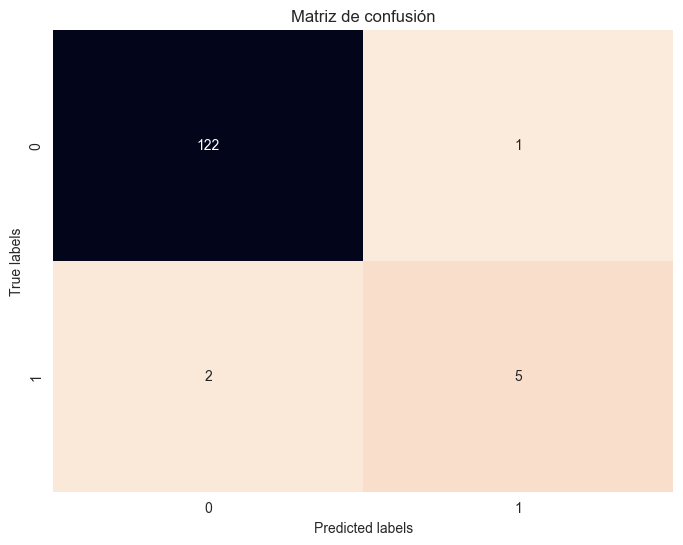

In [11]:
# Crear la matriz de confusión para el conjunto de prueba
cm_test_tree = confusion_matrix(y_test, y_pred_test_tree)

# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_tree, annot=True, fmt='g', cmap='rocket_r', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz de confusión')
plt.show()

Seleccione tres métricas de evaluación para este modelo de clasificación y describa el significado de cada una de ellas para el modelo creado.

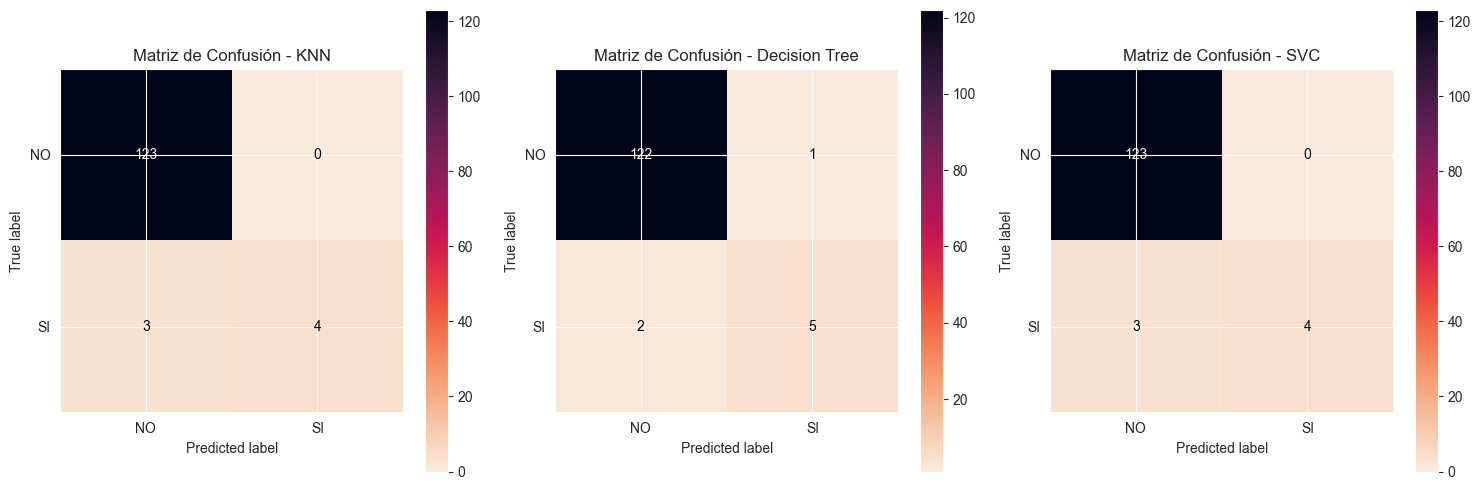

In [12]:
# Se visualizan las tres matrices de confusión
matrices = [cm_test_knn, cm_test_tree, cm_test_svc]
modelos = ['KNN', 'Decision Tree', 'SVC']

# Paleta de colores que prefieras, por ejemplo, 'Blues', 'Greens', 'Oranges', etc.
colores = ['Blues', 'Greens', 'Oranges']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (m, modelo, color) in enumerate(zip(matrices, modelos, colores)):
    ax = axes[i]
    cm_display = ConfusionMatrixDisplay(m, display_labels=['NO', 'SI'])
    
    # Configura el color de la matriz de confusión
    cm_display.plot(ax=ax, cmap='rocket_r')
    
    ax.set_title(f'Matriz de Confusión - {modelo}')

plt.tight_layout()
plt.show()


Debido a la notable disparidad en la variable objetivo en nuestro conjunto de datos, hemos optado por utilizar el F1 Score (Test_F1) como la métrica de evaluación principal. Esta elección se basa en su capacidad para combinar la precisión (proporción de resultados correctos en relación con el total de muestras seleccionadas) y la exhaustividad (proporción de resultados correctos en relación con el total de resultados que se pretenden identificar). De esta manera, se busca lograr un equilibrio ponderado entre ambas medidas.

En cuanto a esta métrica específica, el modelo de Árbol de Decisión ha demostrado el F1 Score más destacado, alcanzando un valor de 0.77. Sin embargo, es fundamental señalar que aún existe un margen considerable de error en las predicciones relacionadas con individuos que eventualmente serán hospitalizados. Este aspecto se confirma al examinar detenidamente las correspondientes matrices de confusión.

Realice un diagrama de la importancia de cada variable respecto a la clasificación de la variable objetivo

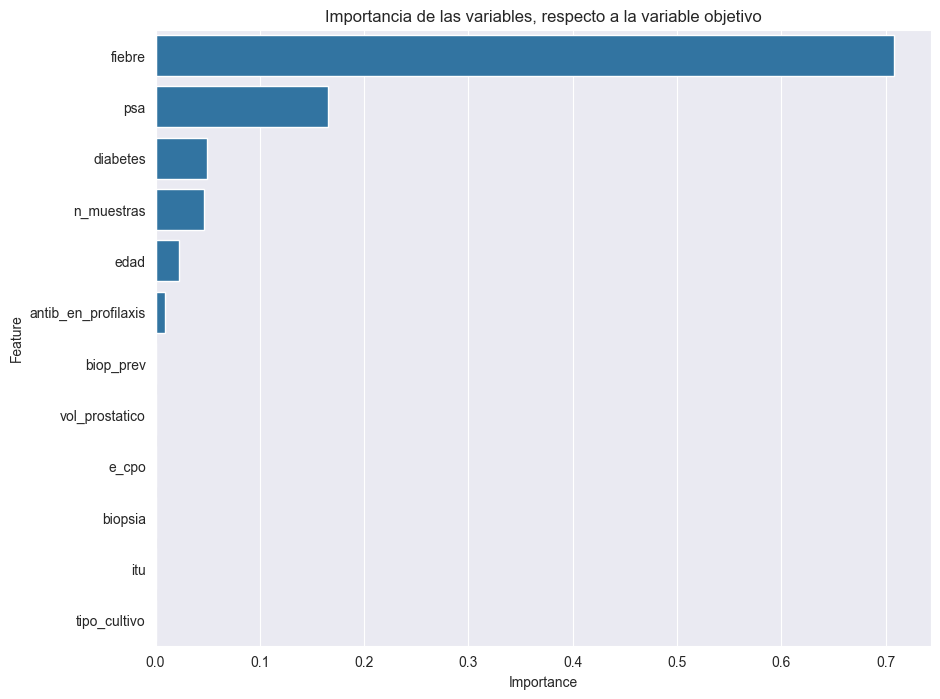

In [13]:
# Visualizar la importancia de las características
feature_importances = best_tree_estimator.feature_importances_

# Crear un DataFrame para facilitar la visualización
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Ordenar el DataFrame por importancia
features_df = features_df.sort_values(by='Importance', ascending=False)

# Crear el gráfico
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Importancia de las variables, respecto a la variable objetivo')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Instancien, entrenen y predigan sobre un modelo de k-vecinos asignando una cantidad de vecinos k-aribitraria. 

## Usando reducción de dimensionalidad (PCA)
En la segunda estrategia, evaluamos los modelos bajo distintos escenarios de reducción de dimensionalidad, aplicando Análisis de Componentes Principales (PCA). Comenzamos estandarizando los datos con StandardScaler y luego definimos cuatro escenarios de reducción a 3, 5, 8 y 10 componentes. A través de un ciclo iterativo, reducimos la dimensionalidad y entrenamos los modelos. Las métricas óptimas para cada modelo en cada escenario se registran en un diccionario, facilitando la comparación y visualización detallada de los resultados.

In [14]:
# Se estandarizan los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ros)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Se define un diccionario para almacenar resultados
results = {}

# Se definen los números de componentes principales
num_components = [3, 5, 8, 10]

for n in num_components:
    
    # Se aplica PCA
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Se define y entrena el modelo KNN
    knn = KNeighborsClassifier()
    param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
    grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5)
    grid_search_knn.fit(X_train_pca, y_train_ros)
    
    best_knn = grid_search_knn.best_estimator_
    knn_pred_train = best_knn.predict(X_train_pca)
    knn_pred_test = best_knn.predict(X_test_pca)
    knn_best_params = grid_search_knn.best_params_

    # Se define y entrena el modelo Decision Tree
    tree = DecisionTreeClassifier()
    param_grid_tree = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    grid_search_tree = GridSearchCV(tree, param_grid_tree, cv=5)
    grid_search_tree.fit(X_train_pca, y_train_ros)

    best_tree = grid_search_tree.best_estimator_
    tree_pred_train = best_tree.predict(X_train_pca)
    tree_pred_test = best_tree.predict(X_test_pca)
    tree_best_params = grid_search_tree.best_params_

    # Se define y entrena el modelo SVC
    svc = SVC(probability=True)
    param_grid_SVC = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
    grid_search_svc = GridSearchCV(svc, param_grid_SVC, cv=5)
    grid_search_svc.fit(X_train_pca, y_train_ros)

    best_svc = grid_search_svc.best_estimator_
    svc_pred_train = best_svc.predict(X_train_pca)
    svc_pred_test = best_svc.predict(X_test_pca)
    svc_best_params = grid_search_svc.best_params_

    # Se almacenan los resultados en el diccionario
    results[n] = {
        'KNN': (knn_pred_train, knn_pred_test, best_knn),
        'Tree': (tree_pred_train, tree_pred_test, best_tree),
        'SVC': (svc_pred_train, svc_pred_test, best_svc)
    }

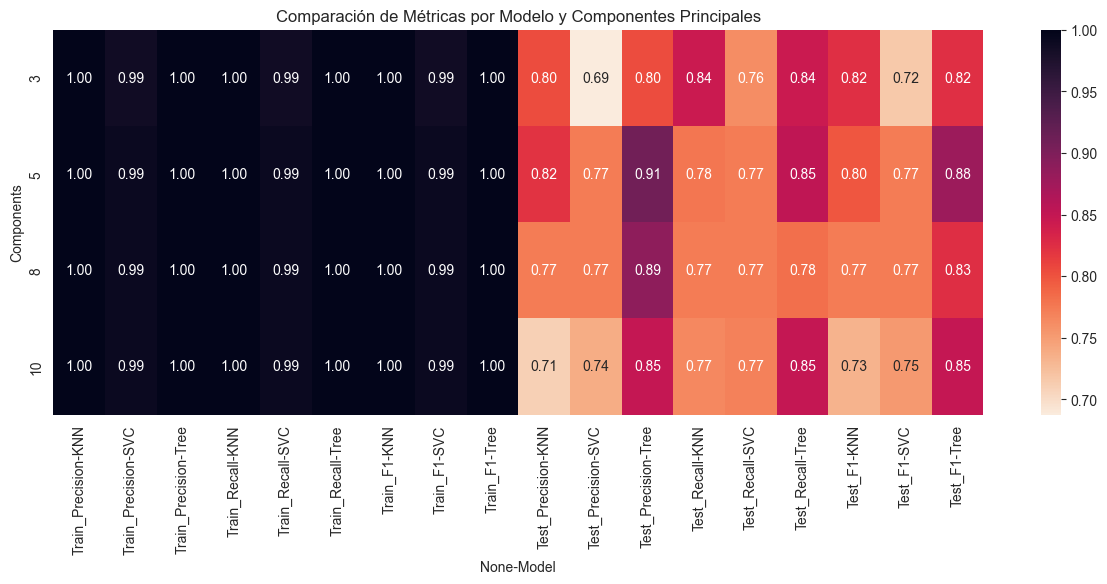

In [16]:
# Crear una lista de diccionarios para almacenar los resultados
summary_results = []

for n, models in results.items():
    for model_name, (y_train_pred, y_test_pred, best_model) in models.items():
        report_train = classification_report(y_train_ros, y_train_pred, output_dict=True)
        report_test = classification_report(y_test, y_test_pred, output_dict=True)

        summary_results.append({
            'Components': n,
            'Model': model_name,
            'Train_Precision': report_train["macro avg"]["precision"],
            'Train_Recall': report_train["macro avg"]["recall"],
            'Train_F1': report_train["macro avg"]["f1-score"],
            'Test_Precision': report_test["macro avg"]["precision"],
            'Test_Recall': report_test["macro avg"]["recall"],
            'Test_F1': report_test["macro avg"]["f1-score"]
        })

# Crear un DataFrame a partir de la lista de resultados
df_summary = pd.DataFrame(summary_results)

# Reorganizar el DataFrame para tener una columna para cada métrica
df_summary_metrics = df_summary.pivot(index='Components', columns='Model')

# Elegir las métricas que deseas visualizar (por ejemplo, precisión, recall, F1-score)
metrics_to_show = ['Train_Precision', 'Train_Recall', 'Train_F1', 'Test_Precision', 'Test_Recall', 'Test_F1']
df_metrics_to_show = df_summary_metrics[metrics_to_show]

# Crear un heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(df_metrics_to_show, annot=True, cmap='rocket_r', fmt=".2f")
plt.title('Comparación de Métricas por Modelo y Componentes Principales')
plt.show()

Encuentre el valor óptimo para k

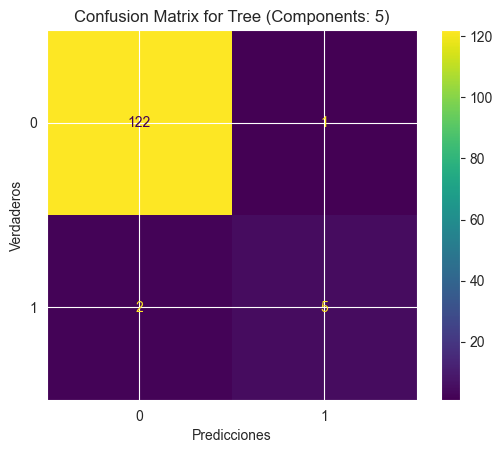

In [17]:
# Encuentra el mejor modelo y métrica en el resumen
best_model_info = df_summary[df_summary['Test_F1'] == df_summary['Test_F1'].max()].iloc[0]

# Obtener información del mejor modelo
best_components = best_model_info['Components']
best_model_name = best_model_info['Model']

# Obtener predicciones del mejor modelo
best_model_preds = results[best_components][best_model_name][1]

# Obtener matriz de confusión
conf_matrix = confusion_matrix(y_test, best_model_preds)

# Crear una visualización de la matriz de confusión
cm_display = ConfusionMatrixDisplay(conf_matrix)
cm_display.plot()
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title(f'Confusion Matrix for {best_model_name} (Components: {best_components})')
plt.show()

Halle las mismas tres métricas de evaluación para este modelo de clasificación y compare los valores para el performance, respecto al árbol de decisión cuyo hiperparámetro **max_depth** se optimizó. ¿Qué puede concluir?


In [18]:
# Se presentan los mejores parámetros para cada modelo
print('PARÁMETROS DE LOS MEJORES MODELOS')
print('KNN:', knn_best_params)
print('Decision Tree:', tree_best_params)
print('SCV:', svc_best_params)

PARÁMETROS DE LOS MEJORES MODELOS
KNN: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Decision Tree: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 10}
SCV: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


En esta perspectiva, destaca el rendimiento superior del modelo de Árbol de Decisión en el contexto de la reducción de dimensionalidad a 5 componentes. En este escenario específico, se observa un F1 Score de 0.91, notablemente mejor que el logrado con el enfoque inicial.

## CONCLUSIONES

*Se realizaron entrenamientos de tres modelos (Árbol de Decisión, K-Vecinos Cercanos y Máquina de Soporte de Vectores) mediante dos enfoques de análisis. Uno consideró todas las variables del conjunto de datos, mientras que el otro exploró cuatro escenarios de reducción de dimensionalidad.*

*En ambos enfoques, se concluyó que el Árbol de Decisión fue el algoritmo más efectivo para clasificar a los pacientes, ya sea hospitalizados o no. No obstante, en el primer enfoque, que utilizó todas las variables del conjunto de datos, el modelo solo alcanzó un F1 Score de 0.77, considerado relativamente bajo. En contraste, en el enfoque de reducción de dimensionalidad, el modelo más destacado fue un Árbol de Decisión con una profundidad máxima de 30, empleando el criterio Gini y con 10 componentes de reducción. En este último escenario, se logró un F1 Score de 0.91, representando un rendimiento aceptable, especialmente dado el considerable desbalance en la clase objetivo.*

### De acuerdo con lo aprendido en el módulo, ¿Cómo cree que se puede mejorar el performance de este modelo? 

*El gran desequilibrio de los datos ha sido un gran inconveniente, seria mejor intentar este modelo con un dataset más equilibrado y así lograr un mejor entrenamiento.*